In [ ]:
pip install datareader

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install numpy-financial

In [ ]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import seaborn as sns
from scipy.optimize import minimize


## Group Assignment
### Team Number: 18
### Team Member Names: Alfred Jade Jenna
### Team Strategy Chosen: SAFE

---
## Filtering
We must filter through ``Tickers.csv`` file as not all stocks will be useful for our simulation. This data cleaning ensures that we refine the historical stock data to simulate portfolios that will be most realistic and to remove runtime errors that could occur due to lack of sufficient data.

### We must remove tickers that:
* Are not listed in USD or CAD
* Traded below average monthly volume of 150,000 shares
* Insufficient market data for January 1 2023 to October 1 2023
* Drop months with less than 18 trading days
* Insufficient data

In [ ]:
filtered_volume_list = [] # Define empty list
def read_ticker_csv(csv):
    # Load CSV into pandas DF
    ticker_df = pd.read_csv(csv)
    ticker_df.columns = ['Tickers'] # Name column
    ticker_df = ticker_df.drop_duplicates() # Dropping duplicates
    tick_list = ticker_df['Tickers'].tolist() # Creating list of ticker
    filtered_list = [] # Defining empty list

    # Function that takes in a list of ticker strings, creating a list with elements as valid tickers
    # Valid tickers must be listed in USD or CAD. The resulting list is defined as filtered_list
    def filter_valid(tickers):
        for ticker in tickers:
            try:
                temp_tick = yf.Ticker(ticker)
                if temp_tick.fast_info['currency'] == 'USD' or temp_tick.fast_info['currency'] == 'CAD':
                    filtered_list.append(ticker)
                else:
                    print(f'{ticker} is not listed in USD or CAD, therefore has been removed')
            except KeyError as error:
                    print(f'Stock {ticker} not found, Dropped. Error: {error}')

    filter_valid(tick_list)

    print('\n\nNow making sure each stock meets the volume and trading day requirements.\n')


    # Function to filter out the months of a stock history that have less than 18 trading days
    def filter_months(stock_history):
        # Extract the month from the 'Date' column
        stock_history['Month'] = stock_history.index.to_period('M')
        # Count the number of trading days for each month
        trading_days = stock_history.groupby('Month').size()
        # Filter out months with fewer than 18 trading days
        invalid_months = trading_days[trading_days < 18].index
        # Print message for each removed month
        for invalid_month in invalid_months:
            print(f'Data for month {invalid_month} has been removed as it has less than 18 trading days.')
        # Filter the stock history based on valid months
        filtered_stock_history = stock_history[~stock_history['Month'].isin(invalid_months)]
        # Drop the 'Month' column as it's no longer needed
        filtered_stock_history = filtered_stock_history.drop(columns='Month')
        return filtered_stock_history

    # Checking to make sure each stock has a valid closing price on the Nov 24th 2023
    def has_closing_price(ticker):
        # Setting start and end date variables for the purpose of checking
        start_x = pd.to_datetime('2023-11-01')
        end_x = (datetime.now()+timedelta(days=1)).strftime('%Y-%m-%d')
        # Obtain closing history for ticker
        ticker_hist = (yf.download(ticker, start=start_x, end=end_x)).Close
        # If date is in the index for closing history
        if '2023-11-24' in ticker_hist.index.strftime('%Y-%m-%d').tolist():
            return False # Returns false since we are using this as a case when the date is NOT found
        else:
            return True



    # Set start and end date to calculate average monthly volume for
    start_date = '2023-01-01'
    end_date = '2023-10-01'

    # For loop cycling through each ticker that was filtered for CAD and USD
    for ticker in filtered_list:
        stock_hist = yf.download(ticker, start=start_date, end=end_date) # Get history
        if stock_hist.dropna().empty: # Drop the ticker if there is no history available
            print(f'Ticker {ticker} has no historical data and has been dropped')
        elif has_closing_price(ticker):
            print(f'Ticker {ticker} has no closing price for today and has been dropped')
        else: # If ticker has valid history
            filtered_stock_hist = filter_months(stock_hist)
            num_months = len(filtered_stock_hist.index.to_period('M').unique())
            avg_monthly_vol = (filtered_stock_hist.Volume.sum())/num_months # Calculating the average monthly volume
            if avg_monthly_vol >= 150000:
                filtered_volume_list.append(ticker) # Add ticker to list if it passes the requirement
            else: # Print statement if not meeting requirement
                print(f'{ticker} did not meet the minimum average monthly volume requirement amd has been dropped')


    print(f'Valid Tickers: {filtered_volume_list}')


read_ticker_csv('Tickers.csv')

Stock AGN not found, Dropped. Error: 'currentTradingPeriod'
Stock CELG not found, Dropped. Error: 'currentTradingPeriod'
Stock MON not found, Dropped. Error: 'currentTradingPeriod'
Stock RTN not found, Dropped. Error: 'currentTradingPeriod'


Now making sure each stock meets the volume and trading day requirements.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 co

---

## Portfolio Optimization With The Monte Carlo Simulation

We use a Monte Carlo Simulation to create repeated samplings of portfolios to predict a variety of outcomes. Repeated sampling elimates error and random variables when predicting market behaviour of stocks. From the repeated samplings of our Monte Carlo simulation we can simulate portfolios of many different weights, and analyze these portfolios to see which one will give us minimal change.

### What's the Monte Carlo Simulation?

The Monte Carlo Simulation can be compared to rolling dice, instead of manually calculating the probability of each outcome, we roll the dice repeatedly to see what happens most often. This model uses computing to simulate many outcomes, the larger the sample size, the more accurate the model. That's the premise of what we're doing here, but with stock portfolios.

### Setting Up Our Portfolio Weights

Each investment in our portfolio will vary, the weight of the investment is the percentage of value in relation to the portfolio. We aim to optimize the weight of each investment in our portfolio for minimal change. The sum of the weight of the portfolio will be 100%. Optimization will analyze which combinations of weighting of the investments will generate most returns, there are thousands of possibilities for the weightings of each stocks in our portfolio and we will investigate many.

We do this part with code that looks like this:

```python
weights = np.random.random(size=n)
weights /= np.sum(weights)
```

This code randomly picks the weights for us and then makes sure they add up to 100%.

## How Do We Choose the Best Portfolio?

To figure out which portfolio is the best for a risk-averse investor, we use something called the Sharpe Ratio. It represents the returns that can be made per unit risk. However, for a risk-averse portfolio, we want to minimize risk and ensure the portfolio's value remains stable over time.

### Sharpe Ratio: Balancing Returns and Stability

The Sharpe Ratio formula looks like this:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

- \($R_p$) is the expected return from the portfolio.
- \($R_f$)  is the risk-free rate (often set to zero).
- \($\sigma_p$) is the portfolio's standard deviation of returns (volatility).

For a risk-averse portfolio, we prioritize minimizing \($\sigma_p$) to ensure the portfolio's value remains stable over time.

### Stability Coefficient: Emphasizing Minimal Fluctuations

$$
\text{Stability Coefficient} = \frac{\text{Sharpe Ratio}}{\sigma_p}
$$

The lower the \($\sigma_p$), the higher the Stability Coefficient. This metric rewards portfolios that have consistent returns with minimal fluctuation.

### Objective: Maximize Stability

To optimize for a risk-averse portfolio, we aim to maximize the Stability Coefficient. This means choosing a portfolio with consistent returns and minimal volatility.

By using the Stability Coefficient, we ensure the portfolio remains as stable as possible over time, aligning with a risk-averse investment strategy.

### Running the Numbers

From the preprocessed data, we calculate annualized return, annualized volatility, and the Sharpe Ratio. These statistics help us better understand the nature of the risks and returns of the stocks in our list of tickers. These statistics will help us simulate the performance of the stocks, and choose the stocks that will generate the most stable returns in our portfolio.

Annualized volatility is a quantifier of the risk of a stock; it represents the volatility of the share price over time. A stock with high annualized volatility is considered risky because the prices fluctuate greatly annually, meaning the stock can generate high losses or returns quickly. For a risk-averse portfolio, we aim to minimize annualized volatility to ensure stable returns.

The Sharpe Ratio quantifies the relationship between risk and return of a stock. The Sharpe Ratio is a tool to calculate investment return per unit of risk. For a risk-averse strategy, we use the Stability Coefficient, which adjusts the Sharpe Ratio to focus on minimizing volatility:

$$
\text{Stability Coefficient} = \frac{\text{Sharpe Ratio}}{\sigma_p}
$$

The higher the Stability Coefficient, the better - signaling that the investment will have consistent returns with minimal risk. We simulate many different portfolios with various weight combinations. For each one, we calculate the Stability Coefficient. We choose the portfolio with the highest Stability Coefficient to maximize stability and minimize risk. Our strategy that favors stability focuses on the least volatile stocks, which can provide us with consistent returns over time.

### Variance

Variance is a measure of how dispersed data points are from their average value. This is used to examine how volatile a stock is; if it has high variance, it indicates a risky stock. High variance indicates that a stock's value is distant from the average values, indicating variability. For a risk-averse portfolio, we aim to minimize variance.

$$
\sigma^2 = \frac{\sum_{i=1}^n (x_i - \mu)^2}{n}
$$

### Covariance

Covariance is a measure of the correlation between two data sets. We use it to measure the change in a stock's returns in relation to the change in a market's returns. Covariance is a vector quantity; the magnitude indicates how strong the correlation is, and +/- indicates whether it's a negative or positive correlation. Covariance is particularly useful for determining the beta of stocks in relation to the market.

$$
\text{cov}_{x,y} = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{N-1}
$$

### Beta

Beta is a measure of volatility or risk. It assesses a stock's performance in relation to the market, assessing systemic risk, which is inherent to the market and cannot be diversified away. Beta represents how a stock will behave in the market. For a risk-averse portfolio, we aim for low beta to minimize exposure to market volatility.

$$
\beta = \frac{\text{cov}(R_s, R_m)}{\text{var}(R_m)}
$$

- \($R_s$) are stock returns
- \($R_m$) are market returns

By focusing on minimizing variance, covariance, and beta, we aim to construct a risk-averse portfolio that maintains its value over time, providing consistent returns with minimal fluctuations.


In [ ]:
# Define dates
start_date = '2023-01-01'
end_date = '2023-11-25'

In [ ]:
# Constants
tickers = filtered_volume_list
max_stocks = 22  # Maximum number of stocks
min_stocks = 10  # Minimum number of stocks
MarketIndex = "^GSPC"  # S&P 500 as the market index

# Fetch historical data for the market index
market_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date).filter(like="Close")
market_hist["Returns"] = market_hist["Close"].pct_change() * 100

market_var = market_hist["Returns"].var()

# Function to calculate beta for a stock
def get_stock_beta(stock_ticker, marketVar=market_var):
    stock_hist = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close'].dropna().pct_change() * 100
    binary_portfolio = pd.DataFrame({'Market': market_hist["Returns"], 'Stock': stock_hist})
    beta = (binary_portfolio.cov() / marketVar)['Stock'].loc("Market")
    return beta

# Function to calculate additional factors (e.g., volatility, mean returns, etc.) for a stock
def calculate_factors(stock_ticker):
    stock_hist = yf.Ticker(stock_ticker).history(start=start_date, end=end_date)['Close']
    stock_hist = stock_hist.dropna()
    returns = stock_hist.pct_change() * 100
    volatility = returns.std()
    mean_return = returns.mean()
    # Add more factors as needed
    return volatility, mean_return

# Calculate beta values and additional factors for all tickers
stock_factors = {}
for ticker in tickers:
    beta = get_stock_beta(ticker)
    volatility, mean_return = calculate_factors(ticker)
    stock_factors[ticker] = {
        'Beta': beta,
        'Volatility': volatility,
        'MeanReturn': mean_return
    }

# Define a scoring function to rank stocks based on multiple factors
def score_stock(stock):
    # Customize the scoring logic to prioritize low volatility and low beta
    return stock['Volatility'] + stock['Beta'] - stock['MeanReturn']

# Sort the tickers based on the score
sorted_tickers = sorted(tickers, key=lambda ticker: score_stock(stock_factors[ticker]))

# Choose between 10 and 22 stocks
selected_tickers = sorted_tickers[:max_stocks] if len(sorted_tickers) >= max_stocks else sorted_tickers[:min_stocks]

print("Selected Tickers based on Risk-Averse Strategy:")
print(selected_tickers)


Selected Tickers based on Enhanced Strategy:
Tickers.csv


[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

/var/folders/ct/57ydg6rn5v16zbbf8_l1ggy80000gn/T/ipykernel_82665/4159788180.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/ct/57ydg6rn5v16zbbf8_l1ggy80000gn/T/ipykernel_82665/4159788180.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/var/folders/ct/57ydg6rn5v16zbbf8_l1ggy80000gn/T/ipykernel_82665/4159788180.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/ct/57ydg6rn5v16zbbf8_l1ggy80000gn/T/ipykernel_82665/4159788180.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() i

Best Portfolio:
   Ticker       Price Currency       Shares          Value     Weight
1    ABBV  189.908568      CAD    47.995493    9114.755271   1.072504
2     ABT  140.880473      CAD   130.183549   18340.319987   2.158047
3     ACN  457.467805      CAD    86.614570   39623.377251   4.662357
4     AIG   89.305096      CAD   255.472560   22815.001616   2.684569
5    AMZN  200.960444      CAD   639.227397  128459.421287  15.115412
6     AXP  225.173194      CAD     3.331333     750.126934   0.088265
7      BA  301.290009      CAD     6.729629    2027.569857   0.238578
8     BAC   40.715236      CAD  1690.116121   68813.476030   8.097063
9    BIIB  317.655530      CAD   142.610637   45301.057663   5.330432
10     BK   64.845825      CAD   721.670570   46797.323404   5.506493
11    BLK  999.871947      CAD    66.525428   66516.909037   7.826834
12    BMY   68.146320      CAD    89.407575    6092.797161   0.716920
13      C   61.942486      CAD   436.830141   27058.344969   3.183870
14  

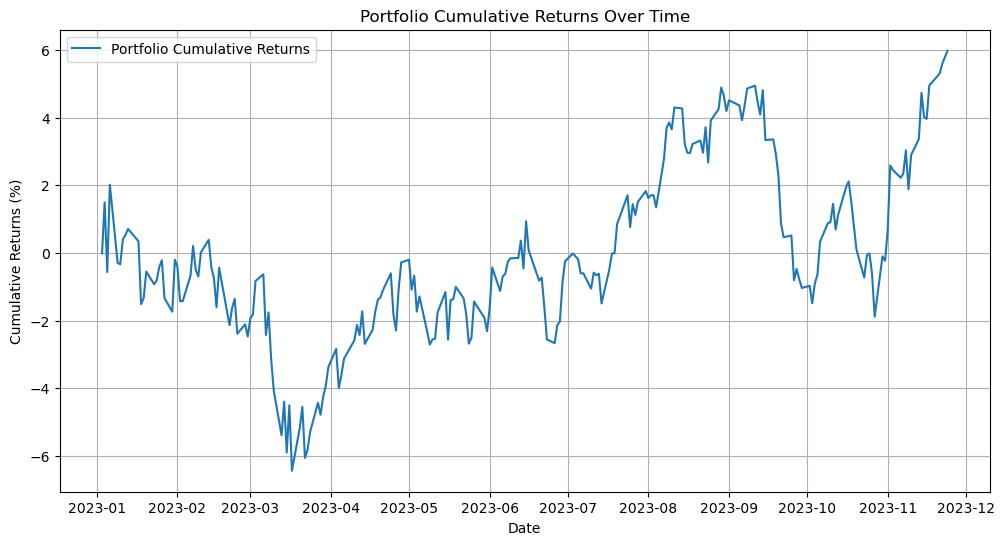

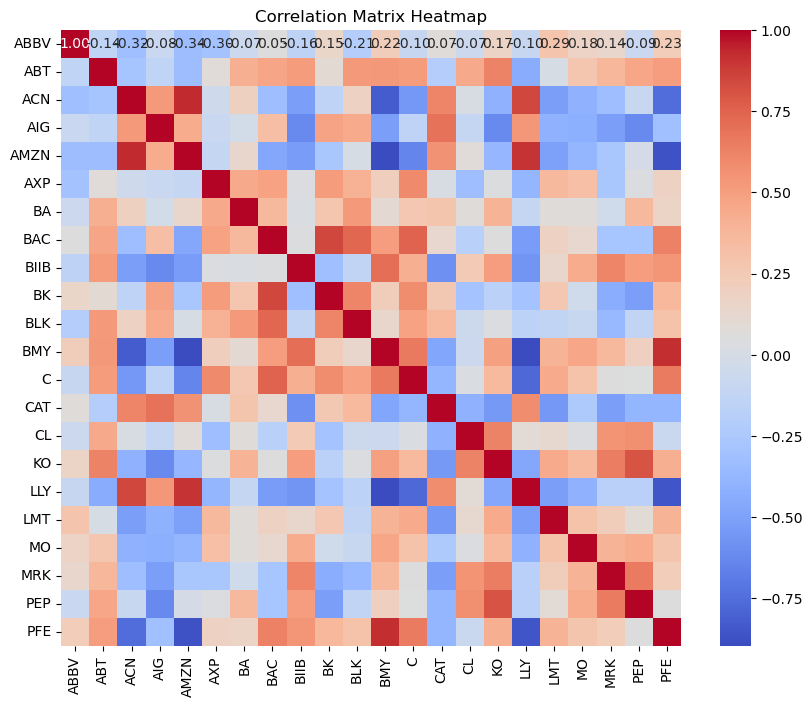

Sum of Weights: 0.9999999999999999


In [ ]:
# Constants
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
risk_free_rate = 0.02  # Risk-free rate (e.g., Treasury yield)
selected_tickers = sorted(selected_tickers)
mc_weights = []
type_currency = pd.DataFrame(selected_tickers)
Portfolio_Final = pd.DataFrame(index=range(1, len(selected_tickers) + 1))
portfolio = pd.DataFrame()
portfolio_shares = {}
portfolio_metrics = []  # Store portfolio metrics for all simulations
data = yf.download(selected_tickers, start=start_date, end=end_date, threads=True)['Adj Close']

def get_portfolio_weights(num_stocks, max_weight=0.20):
    # Generate random weights for the given number of stocks
    weights = np.random.random(num_stocks)
    # Normalize the weights so they sum up to 1
    weights /= np.sum(weights)
    # Apply the maximum weight limit and renormalize
    weights = np.minimum(weights, max_weight)
    weights /= np.sum(weights)
    return weights

def simulate(_):
    # Generate random portfolio weights
    weights = get_portfolio_weights(len(selected_tickers))

    # Data preprocessing to handle missing values
    data.dropna(how='all', inplace=True)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    portfolio = pd.DataFrame(index=data.index)
    portfolio_shares = {}
    total_spent = 0

    # Calculate the number of shares to buy for each stock based on portfolio weights
    for i, ticker in enumerate(selected_tickers):
        allocation = weights[i] * (cash - len(selected_tickers) * fee_per_stock)
        initial_ticker_price = data[ticker].iloc[0]
        shares = allocation / initial_ticker_price
        portfolio_shares[ticker] = shares
        total_spent += shares * initial_ticker_price + fee_per_stock

    # Adjust the weights if the total allocation exceeds the budget
    if total_spent > cash:
        scale_factor = cash / total_spent
        for ticker in selected_tickers:
            portfolio_shares[ticker] *= scale_factor
        total_spent = sum(portfolio_shares[ticker] * data[ticker].iloc[0] for ticker in selected_tickers) + len(selected_tickers) * fee_per_stock

    # Construct the portfolio
    for ticker in selected_tickers:
        portfolio[ticker] = portfolio_shares[ticker] * data[ticker]

    portfolio['Total Value'] = portfolio.sum(axis=1)
    initial_portfolio_value = portfolio['Total Value'].iloc[0]
    total_portfolio_value = portfolio['Total Value'].iloc[-1]

    # Recalculate the final weights based on the final value of each stock
    final_weights = {ticker: (portfolio_shares[ticker] * data[ticker].iloc[-1]) / total_portfolio_value for ticker in selected_tickers}

    portfolio['Percent Return'] = portfolio['Total Value'].pct_change() * 100
    std = portfolio['Percent Return'].std()
    avg_return = portfolio['Percent Return'].mean()
    excess_return = avg_return - risk_free_rate
    stability_coefficient = -std  # Using standard deviation directly for minimal volatility

    # Store portfolio metrics
    portfolio_metrics.append({
        'Weights': final_weights,
        'Stability Coefficient': stability_coefficient,
        'Portfolio Shares': portfolio_shares,
        'Final Portfolio Value': total_portfolio_value
    })

def monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, ticker_list, risk_free_rate=risk_free_rate):
    sss = time.time()

    # Loop that checks for the currency of each ticker. If it is USD it is converted to CAD
    # Our portfolio standard currency is in CAD
    for ticker in list(data.columns):
        temp = yf.Ticker(ticker)
        cur = temp.fast_info['currency']
        if cur == 'USD':
            rate = yf.download('USDCAD=x', start=start_date, end=end_date, threads=True)['Close']
            data[ticker] = data[ticker] * rate

    # Threading
    # Ensuring that script is being run at top level
    if __name__ == "__main__":
        num_threads =  4 # Can be adjusted
        num_iterations = num_portfolios
        # Create a list to store thread objects
        threads = []

        # Define the function to be executed in each thread
        def run_thread(start, end):
            for i in range(start, end):
                simulate(i)

        # Calculate the number of iterations each thread will handle
        iterations_per_thread = num_iterations // num_threads

        # Create and start threads
        for i in range(num_threads):
            start = i * iterations_per_thread
            end = (i + 1) * iterations_per_thread if i < num_threads - 1 else num_iterations
            thread = threading.Thread(target=run_thread, args=(start, end))
            threads.append(thread)
            thread.start()

        # Wait for all threads to complete
        for thread in threads:
            thread.join()
    else:
        print('Error: Please ensure script is being run at top level.')

    eee = time.time()
    elapsed_time = sss - eee
    print(f"Total runtime: {elapsed_time} seconds")
    # sort portfolios by Stability Coefficient and get the best portfolio
    portfolio_metrics.sort(key=lambda x: x['Stability Coefficient'])
    best_portfolio = portfolio_metrics[0]


    type_currency.index = type_currency.index + 1
    # create the Portfolio_Final DataFrame for the best portfolio
    Portfolio_Final['Ticker'] = ticker_list
    Portfolio_Final['Price'] = data.iloc[-1].values
    Portfolio_Final['Currency'] = 'CAD'
    Portfolio_Final['Shares'] = [best_portfolio['Portfolio Shares'][ticker] for ticker in ticker_list]
    Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
    Portfolio_Final['Weight'] = [best_portfolio['Weights'][ticker] * 100 for ticker in ticker_list]  # Convert to percentage

    # print the best portfolio and metrics
    print("Best Portfolio:")
    print(Portfolio_Final)
    print("Stability Coefficient:", best_portfolio['Stability Coefficient'])
    print("Portfolio Shares:", best_portfolio['Portfolio Shares'])

    return [best_portfolio['Weights'], best_portfolio['Stability Coefficient'], best_portfolio['Final Portfolio Value']]

# Usage
# Define the dates for the simulation
num_portfolios = 20000  # Number of portfolio simulations

# Run the Monte Carlo portfolio optimization simulation
mc_results = monte_carlo_portfolio_optimization(num_portfolios, start_date, end_date, selected_tickers)
mc_weights, mc_stability_coefficient, mc_final_value = mc_results

# print the sum of weights to verify it does not exceed 100%
sum_of_weights = sum(mc_weights.values())
print("Sum of Weights:", sum_of_weights)


## Risk-Averse Portfolio Optimization Using SLSQP

### The Core Idea

Our primary goal is to minimize the risk of the portfolio while aiming for stable returns over time. This is a shift from the traditional method of maximizing the Sharpe Ratio, which considers both returns and volatility (risk). By focusing solely on minimizing volatility, we're gearing up for a more conservative investment stance.

### How Do We Achieve This?

We use an optimization algorithm known as Sequential Least SQuares Programming (SLSQP), but with a twist:

* **Objective Function - Minimize Volatility**: The heart of our method is the objective function. Instead of the Sharpe Ratio or expected return, we use the portfolio's volatility as our guiding star. Our aim is to find the combination of stock weights that gives us the lowest possible volatility.

* **Constraints - Keeping It Real**: We still have rules to follow. The sum of the weights of all stocks in our portfolio must equal 100%. This ensures our portfolio is fully allocated across our chosen stocks.

* **Bounds - Flexibility Within Limits**: Each stock can only take up a certain percentage of our portfolio (between 1% and 22%). This prevents putting all our eggs in one or a few baskets, which is a basic risk management principle.

### The Optimization Process

Here's how the process unfolds:

* **Data Gathering**: We pull historical data for our selected stocks to understand their past performance.

* **Calculating Volatility**: We focus on the standard deviation of the daily returns of these stocks, as this will be the backbone of our volatility minimization strategy.

* **Running the Optimization**: With our objective function set to minimize volatility, the SLSQP algorithm gets to work. It intelligently navigates through various weight combinations, seeking the one that promises the lowest volatility.

* **Result Analysis**: The output is a set of weights for each stock in our portfolio that theoretically offers the lowest volatility based on historical data.


In [ ]:
# Constants
cash = 750000  # Total budget in CAD
fee_per_stock = 4.95  # Flat fee per stock in CAD
tickers = selected_tickers
start_sl = '2020-01-01'
end_sl = '2023-01-01'

# Fetching historical stock data from Yahoo Finance. We're looking at data from 2020 to 2023.
# This data will help us figure out how these stocks have performed in the past.
data = yf.download(tickers, start=start_sl, end=end_sl, threads=True)['Adj Close']

# Loop that checks for the currency of each ticker. If it is USD it is converted to CAD
# Our portfolio standard currency is in CAD
for ticker in list(data.columns):
    temp = yf.Ticker(ticker)
    cur = temp.fast_info['currency']
    if cur == 'USD':
        rate = yf.download('USDCAD=x', start=start_sl, end=end_sl, threads=True)['Close']
        data[ticker] = data[ticker] * rate

# Calculating daily percentage changes in stock prices. This tells us how much each stock's price
# has changed from one day to the next.
returns = data.pct_change().dropna()

# Defining a function to calculate the portfolio's volatility based on the weights of each stock.
def portfolio_volatility(weights):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return portfolio_std_dev

# Our objective function, which we want to minimize.
def objective_function(weights):
    return portfolio_volatility(weights)

# Setting up our constraints. We want the sum of our weights to be 1, meaning we use all our money.
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Setting bounds for our weights. Each stock can only take up between 1% and 22% of our portfolio.
# This prevents us from putting too much into any one stock (diversification is key!).
bounds = tuple((0.01, 0.22) for _ in tickers)

# Our initial guess for the weights. We start off evenly distributed, but the optimizer will adjust this.
initial_guess = np.random.random(len(tickers))
initial_guess /= np.sum(initial_guess)

# Running the optimization! We use the SLSQP method to minimize our volatility function.
# The optimizer will change the weights around to find the combination where our volatility is as low as possible.
result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# If the optimization didn't work out, we'll know here.
if not result.success:
    raise ValueError("Optimization did not converge. Please check the setup and data.")

# Finally, our optimal weights. These are the weights that the optimizer found to give us the lowest volatility.
optimal_weights = result.x

# Calculate the number of shares to buy for each stock based on the optimal weights and cash available
portfolio_shares = {}
total_spent = 0

for i, ticker in enumerate(tickers):
    stock_price = data[ticker].iloc[-1]  # Get latest stock price
    allocation = cash * optimal_weights[i]  # Calculate the allocation for each stock
    shares = (allocation - fee_per_stock) / stock_price  # Calculate the number of shares
    portfolio_shares[ticker] = shares
    total_spent += shares * stock_price + fee_per_stock

# Ensure that the total spent is within the budget
# Check if the total spent is within the budget, considering the fee for each stock
if total_spent > cash:
    excess_amount = total_spent - cash
    print(f"Warning: The budget was exceeded by {excess_amount:.2f} CAD.")
    print("Adjusting the portfolio to stay within budget.")

    # Calculate the adjustment factor to bring the total spent back to the budget
    adjustment_factor = (cash - fee_per_stock * len(tickers)) / total_spent

    # Adjust the number of shares and total spent for each stock
    for ticker in tickers:
        portfolio_shares[ticker] *= adjustment_factor
    total_spent = cash

    print("Portfolio adjusted successfully.")

# Calculate the total portfolio value
portfolio_value = sum(portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers)

# Create the Portfolio_Final2 DataFrame as per the given rules
Portfolio_Final2 = pd.DataFrame(index=range(1, len(tickers) + 1))
Portfolio_Final2['Ticker'] = tickers
Portfolio_Final2['Price'] = [data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Currency'] = 'CAD'
Portfolio_Final2['Shares'] = [portfolio_shares[ticker] for ticker in tickers]
Portfolio_Final2['Value'] = [portfolio_shares[ticker] * data[ticker].iloc[-1] for ticker in tickers]
Portfolio_Final2['Weight'] = optimal_weights * 100

# Print the Portfolio_Final2 DataFrame
print("Portfolio_Final:")
print(Portfolio_Final2)

# Print the total portfolio value and total weights (should sum to 100%)
print("Total Portfolio Value:", portfolio_value)
print("Total Weight:", sum(Portfolio_Final2['Weight']))

# Finally, print the optimized weights
print("Optimal Portfolio Weights for a Risk-Averse Approach: ")
print(dict(zip(tickers, optimal_weights * 100)))

# Store SLSQP weights in list
slsqp_weights = optimal_weights * 100


## Comparison and Selection of the Final Portfolio

To determine the better portfolio between the Monte Carlo and SLSQP approaches, we evaluate and compare their stability and performance metrics. The following steps outline the process:

### Steps to Compare Portfolios

#### Calculate Metrics for Both Portfolios:

1. **Volatility**: This is the standard deviation of the portfolio returns. A lower volatility indicates a more stable portfolio.
2. **Mean Return**: This is the average expected return of the portfolio. It provides insight into the portfolio's performance.
3. **Sharpe Ratio**: This measures the risk-adjusted return of the portfolio. A higher Sharpe Ratio indicates better risk-adjusted performance.

#### Compare and Choose the Better Portfolio:

1. Prefer the portfolio with lower volatility for better stability.
2. If volatilities are similar, prefer the one with a higher mean return for better performance.


In [ ]:
def calculate_portfolio_metrics(weights, data):
    returns = data.pct_change().dropna()
    portfolio_return = np.dot(returns.mean(), weights) * 252  # Annualized return
    portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_volatility, portfolio_return, sharpe_ratio

# Convert mc_weights to a numpy array
mc_weights_array = np.array([mc_weights[ticker] for ticker in selected_tickers])

# Calculate metrics for Monte Carlo portfolio
mc_volatility, mc_return, mc_sharpe_ratio = calculate_portfolio_metrics(mc_weights_array, data)

# Calculate metrics for SLSQP portfolio
slsqp_volatility, slsqp_return, slsqp_sharpe_ratio = calculate_portfolio_metrics(slsqp_weights / 100, data)  # Convert percentage weights to fractions

# Print the metrics for both portfolios
print("Monte Carlo Portfolio Metrics:")
print(f"Volatility: {mc_volatility:.6f}")
print(f"Mean Return: {mc_return:.6f}")
print(f"Sharpe Ratio: {mc_sharpe_ratio:.6f}")

print("\nSLSQP Portfolio Metrics:")
print(f"Volatility: {slsqp_volatility:.6f}")
print(f"Mean Return: {slsqp_return:.6f}")
print(f"Sharpe Ratio: {slsqp_sharpe_ratio:.6f}")

# Compare and choose the better portfolio
if mc_volatility < slsqp_volatility:
    print("\nMonte Carlo Portfolio is better based on lower volatility.")
    better_portfolio = 'Monte Carlo'
elif slsqp_volatility < mc_volatility:
    print("\nSLSQP Portfolio is better based on lower volatility.")
    better_portfolio = 'SLSQP'
else:
    # If volatilities are similar, compare mean returns
    if mc_return > slsqp_return:
        print("\nVolatilities are similar. Monte Carlo Portfolio is better based on higher mean return.")
        better_portfolio = 'Monte Carlo'
    else:
        print("\nVolatilities are similar. SLSQP Portfolio is better based on higher mean return.")
        better_portfolio = 'SLSQP'

print(f"\nBetter Portfolio: {better_portfolio}")

# Visualizations
metrics = {
    "Monte Carlo": [mc_volatility, mc_return, mc_sharpe_ratio],
    "SLSQP": [slsqp_volatility, slsqp_return, slsqp_sharpe_ratio]
}

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics, index=["Volatility", "Mean Return", "Sharpe Ratio"])

# Plot the metrics
plt.figure(figsize=(14, 6))

# Subplot 1: Volatility
plt.subplot(1, 3, 1)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Volatility"])
plt.title('Volatility')
plt.ylabel('Volatility')

# Subplot 2: Mean Return
plt.subplot(1, 3, 2)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Mean Return"])
plt.title('Mean Return')
plt.ylabel('Mean Return')

# Subplot 3: Sharpe Ratio
plt.subplot(1, 3, 3)
sns.barplot(x=metrics_df.columns, y=metrics_df.loc["Sharpe Ratio"])
plt.title('Sharpe Ratio')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()


### Creating Stocks_Final DataFrame and Exporting to CSV file

In [ ]:
# Create the Stocks_Final DataFrame
if better_portfolio == 'Monte Carlo':
    Stocks_Final = Portfolio_Final[['Ticker', 'Shares']].copy()
else:
    Stocks_Final = Portfolio_Final2[['Ticker', 'Shares']].copy()


# Exporting Stocks_Final DataFrame to CSV file
Stocks_Final.to_csv('Stocks_Group_18.csv')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:


#### Alfred:
Wrote entirely and debugged step 1 for Data Preprocessing where Tickers are extracted, cleaned, and filtered from the CSV.
Debugged and edited method on the extracting 10-22 best tickers from filtered list of tickers.
Debugged and partially wrote Monte Carlo Method.
Debugged and made edits to SLSQP code.
Wrote entirely and debugged last step (final approach) to determine which optimization approach we will base our investment off of.

#### Jade:
Wrote most of the code, method and logic for filtering the tickers based on beta, std, and the variance.

Wrote most of the code, method, and logic for both analysis: Monte Carlo and SLSQP.


#### Jenna:
Final dataframe, export csv, formatting, markdowns(explanation,statistics),editing comments

